# Imports

In [7]:
import kagglehub
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from textblob import TextBlob
from sklearn.pipeline import Pipeline
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
import time
import requests
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import feedparser
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from newspaper import Article
from urllib.parse import urlparse
import spacy
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import textwrap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Load LiarPlus Dataset

In [8]:
path = kagglehub.dataset_download("saketchaturvedi/liarplus")
print("Path to dataset files:", path)

100%|██████████| 3.00M/3.00M [00:00<00:00, 146MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saketchaturvedi/liarplus/versions/1


In [9]:
dataset_path = os.path.join(path, "LIAR-PLUS-master", "dataset")
print(os.listdir(dataset_path))

['val2.tsv', 'train2.tsv', 'test2.tsv']


In [10]:
df_train = pd.read_csv(os.path.join(dataset_path, "train2.tsv"), sep="\t", header=None)
df_val   = pd.read_csv(os.path.join(dataset_path, "val2.tsv"), sep="\t", header=None)
df_test  = pd.read_csv(os.path.join(dataset_path, "test2.tsv"), sep="\t", header=None)

# Data Preprocessing

In [11]:
# names of columns
cols = [
    "index", "id", "label", "statement", "subject", "speaker", "job", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire",
    "context", "justification"
]

In [12]:
# assigning appropriate column names to datasets
df_train.columns = cols
df_val.columns   = cols
df_test.columns  = cols

In [13]:
# drop extra index column
df_train = df_train.drop(columns=["index"])
df_val   = df_val.drop(columns=["index"])
df_test  = df_test.drop(columns=["index"])

In [14]:
for df in [df_train, df_val, df_test]:
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df.reset_index(drop=True, inplace=True)

In [15]:
# remove .json after ID number values
for df in [df_train, df_val, df_test]:
    df["id"] = df["id"].str.replace(".json", "", regex=False)

In [16]:
df_train.head()

,id,label,statement,subject,speaker,job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
0,2635,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [17]:
df_train.shape

(10240, 15)

In [18]:
df_val.shape

(1284, 15)

In [19]:
df_test.shape

(1267, 15)

# Frequency Heuristic

In [20]:
train_freq = df_train.copy()
val_freq   = df_val.copy()
test_freq  = df_test.copy()

In [21]:
def build_frequency_model(df_train):
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix_train = tfidf.fit_transform(df_train['statement'])

    count_vec = CountVectorizer(stop_words='english')
    count_matrix_train = count_vec.fit_transform(df_train['statement'])
    token_freq = np.asarray(count_matrix_train.sum(axis=0)).ravel()
    token_dict = {w: token_freq[i] for i, w in enumerate(count_vec.get_feature_names_out())}

    buzzwords = {'always','never','everyone','nobody','millions','billions','every',
                 'no one','thousands','people say','experts agree'}

    def avg_word_freq(text):
        words = [w for w in text.lower().split() if w in token_dict]
        return np.mean([token_dict[w] for w in words]) if words else 0

    def buzzword_score(text):
        return sum(b in text.lower() for b in buzzwords)

    def repetition_score(text):
        tokens = text.lower().split()
        return 1 - len(set(tokens)) / len(tokens) if tokens else 0

    X_train = pd.DataFrame({
        "tfidf_mean": tfidf_matrix_train.mean(axis=1).A1,
        "word_freq_mean": df_train['statement'].apply(avg_word_freq),
        "buzzword_score": df_train['statement'].apply(buzzword_score),
        "repetition_score": df_train['statement'].apply(repetition_score)
    }).fillna(0)

    le = LabelEncoder()
    y_train = le.fit_transform(df_train['label'])

    model = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(n_estimators=200, random_state=42))])
    model.fit(X_train, y_train)

    return model, tfidf, count_vec, token_dict, buzzwords, le

In [22]:
def predict_frequency_model(df, model, tfidf, count_vec, token_dict, buzzwords, le):
    def avg_word_freq(text):
        words = [w for w in text.lower().split() if w in token_dict]
        return np.mean([token_dict[w] for w in words]) if words else 0

    def buzzword_score(text):
        return sum(b in text.lower() for b in buzzwords)

    def repetition_score(text):
        tokens = text.lower().split()
        return 1 - len(set(tokens)) / len(tokens) if tokens else 0

    tfidf_matrix = tfidf.transform(df['statement'])
    X = pd.DataFrame({
        "tfidf_mean": tfidf_matrix.mean(axis=1).A1,
        "word_freq_mean": df['statement'].apply(avg_word_freq),
        "buzzword_score": df['statement'].apply(buzzword_score),
        "repetition_score": df['statement'].apply(repetition_score)
    }).fillna(0)

    preds = model.predict(X)
    probs = model.predict_proba(X).max(axis=1)

    return pd.DataFrame({
        "id": df["id"],
        "statement": df["statement"],
        "predicted_label": le.inverse_transform(preds),
        "frequency_heuristic_score": probs
    })

In [23]:
model_freq, tfidf_freq, count_vec_freq, token_dict_freq, buzzwords_freq, le_freq = build_frequency_model(train_freq)

val_results = predict_frequency_model(val_freq, model_freq, tfidf_freq, count_vec_freq, token_dict_freq, buzzwords_freq, le_freq)
test_results = predict_frequency_model(test_freq, model_freq, tfidf_freq, count_vec_freq, token_dict_freq, buzzwords_freq, le_freq)

print(val_results.head())

      id                                          statement predicted_label  \
0  12134  We have less Americans working now than in the...           false   
1    238  When Obama was sworn into office, he DID NOT u...       half-true   
2   7891  Says Having organizations parading as being so...            true   
3   8169     Says nearly half of Oregons children are poor.     barely-true   
4    929  On attacks by Republicans that various program...           false   

   frequency_heuristic_score  
0                      0.365  
1                      0.260  
2                      0.385  
3                      0.330  
4                      0.255  


# Echo Chamber

In [24]:
train_echo = df_train.copy()
val_echo   = df_val.copy()
test_echo  = df_test.copy()

In [25]:
def build_echo_chamber_model(df_train):
    topic_party_counts = (df_train.groupby(["subject", "party"]).size().unstack(fill_value=0))

    topic_party_counts["party_concentration"] = (topic_party_counts.max(axis=1) / topic_party_counts.sum(axis=1))

    concentration_map = topic_party_counts["party_concentration"].to_dict()

    df_train["echo_chamber"] = df_train["subject"].map(concentration_map)

    def categorize_echo(value):
        if value <= 0.4:
            return 0
        elif value <= 0.6:
            return 1
        elif value <= 0.8:
            return 2
        else:
            return 3

    df_train["echo_chamber_4class"] = df_train["echo_chamber"].apply(categorize_echo)

    dfs = []
    max_size = df_train["echo_chamber_4class"].value_counts().max()
    for cls in df_train["echo_chamber_4class"].unique():
        df_cls = df_train[df_train["echo_chamber_4class"] == cls]
        df_cls_upsampled = resample(df_cls, replace=True, n_samples=max_size, random_state=42)
        dfs.append(df_cls_upsampled)
    df_train_bal = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

    df_train_bal["subject_length"] = df_train_bal["subject"].apply(lambda x: len(str(x).split(",")))
    df_train_bal["is_political"] = df_train_bal["subject"].apply(lambda x: int("politics" in str(x).lower() or "election" in str(x).lower()))

    le = LabelEncoder()
    df_train_bal["party_encoded"] = le.fit_transform(df_train_bal["party"].fillna("none"))

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_tfidf = vectorizer.fit_transform(df_train_bal["statement"])

    X_train_full = hstack([X_train_tfidf, df_train_bal[["subject_length", "is_political", "party_encoded"]].values,])

    y_train = df_train_bal["echo_chamber_4class"]

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="mlogloss",
    )

    model.fit(X_train_full, y_train)

    return model, vectorizer, le, concentration_map

In [26]:
def predict_echo_chamber_model(df, model, vectorizer, le, concentration_map):
    df = df.copy()
    df["echo_chamber"] = df["subject"].map(concentration_map)

    def categorize_echo(value):
        if value <= 0.4:
            return 0
        elif value <= 0.6:
            return 1
        elif value <= 0.8:
            return 2
        else:
            return 3

    df["echo_chamber_4class"] = df["echo_chamber"].apply(categorize_echo)

    df["subject_length"] = df["subject"].apply(lambda x: len(str(x).split(",")))
    df["is_political"] = df["subject"].apply(lambda x: int("politics" in str(x).lower() or "election" in str(x).lower()))
    df["party_encoded"] = le.fit_transform(df["party"].fillna("none"))

    X_tfidf = vectorizer.transform(df["statement"])
    X_full = hstack([X_tfidf, df[["subject_length", "is_political", "party_encoded"]].values])

    preds = model.predict(X_full)
    probs = model.predict_proba(X_full).max(axis=1)

    return pd.DataFrame(
        {
            "id": df["id"],
            "statement": df["statement"],
            "predicted_echo_class": preds,
            "echo_chamber_score": probs,
        }
    )

In [27]:
model_echo, vectorizer_echo, le_echo, concentration_map = build_echo_chamber_model(train_echo)

val_results_echo = predict_echo_chamber_model(val_echo, model_echo, vectorizer_echo, le_echo, concentration_map)
print(val_results_echo.head())

test_results_echo = predict_echo_chamber_model(test_echo, model_echo, vectorizer_echo, le_echo, concentration_map)
print(test_results_echo.head())

      id                                          statement  \
0  12134  We have less Americans working now than in the...   
1    238  When Obama was sworn into office, he DID NOT u...   
2   7891  Says Having organizations parading as being so...   
3   8169     Says nearly half of Oregons children are poor.   
4    929  On attacks by Republicans that various program...   

   predicted_echo_class  echo_chamber_score  
0                     0            0.373171  
1                     0            0.510800  
2                     3            0.794987  
3                     1            0.577689  
4                     2            0.584880  
      id                                          statement  \
0  11972  Building a wall on the U.S.-Mexico border will...   
1  11685  Wisconsin is on pace to double the number of l...   
2  11096  Says John McCain has done nothing to help the ...   
3   5209  Suzanne Bonamici supports a plan that will cut...   
4   9524  When asked by a repo

# Sensationalism

In [28]:
def build_sensationalism_model(df_train):
    def map_sensationalism_from_counts(row):
        total = row["barely_true"] + row["false"] + row["half_true"] + row["mostly_true"] + row["pants_on_fire"]
        if total == 0:
            return 1
        score = (
            2 * row["barely_true"] +
            3 * row["false"] +
            1 * row["half_true"] +
            0.5 * row["mostly_true"] +
            4 * row["pants_on_fire"]
        ) / total
        if score < 1.5:
            return 0
        elif score < 2.5:
            return 1
        else:
            return 2

    for df in [df_train, df_val, df_test]:
        df["sensationalism"] = df.apply(map_sensationalism_from_counts, axis=1)

    def extract_text_features(text):
        text = str(text)
        exclaim = text.count("!")
        allcaps = len(re.findall(r"\b[A-Z]{2,}\b", text))
        sens_words = sum(1 for w in [
            "shocking","unbelievable","incredible","amazing","outrageous",
            "disaster","terrifying","massive","horrifying","explosive",
            "record-breaking","unprecedented","urgent","worst","best"
        ] if w in text.lower())
        blob = TextBlob(text)
        return exclaim, allcaps, sens_words, abs(blob.sentiment.polarity), blob.sentiment.subjectivity

    feats = df_train["statement"].apply(extract_text_features)
    df_train[["exclaim","allcaps","sens_words","polarity","subjectivity"]] = pd.DataFrame(feats.tolist(), index=df_train.index)

    text_col = "statement"
    meta_features = ["speaker", "party", "context", "job"]
    numeric_features = ["exclaim", "allcaps", "sens_words", "polarity", "subjectivity"]

    preprocessor = ColumnTransformer([
        ("text", TfidfVectorizer(max_features=5000, stop_words="english"), text_col),
        ("cat", OneHotEncoder(handle_unknown="ignore"), meta_features),
        ("num", StandardScaler(), numeric_features)
    ])

    model = XGBClassifier(
        num_class=3,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="mlogloss"
    )

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    X_train = df_train[[text_col] + meta_features + numeric_features]
    y_train = df_train["sensationalism"]

    pipeline.fit(X_train, y_train)

    return pipeline, preprocessor, meta_features, numeric_features

In [29]:
def predict_sensationalism_model(df, pipeline, preprocessor, meta_features, numeric_features):
    df = df.copy()

    def extract_text_features(text):
        text = str(text)
        exclaim = text.count("!")
        allcaps = len(re.findall(r"\b[A-Z]{2,}\b", text))
        sens_words = sum(1 for w in [
            "shocking","unbelievable","incredible","amazing","outrageous",
            "disaster","terrifying","massive","horrifying","explosive",
            "record-breaking","unprecedented","urgent","worst","best"
        ] if w in text.lower())
        blob = TextBlob(text)
        return exclaim, allcaps, sens_words, abs(blob.sentiment.polarity), blob.sentiment.subjectivity

    feats = df["statement"].apply(extract_text_features)
    df[["exclaim","allcaps","sens_words","polarity","subjectivity"]] = pd.DataFrame(feats.tolist(), index=df.index)

    X = df[["statement"] + meta_features + numeric_features]
    preds = pipeline.predict(X)
    probs = pipeline.predict_proba(X).max(axis=1)

    return pd.DataFrame({
        "id": df["id"],
        "statement": df["statement"],
        "predicted_sensationalism": preds,
        "sensationalism_score": probs
    })

In [30]:
sens_pipeline, sens_preproc, sens_meta, sens_num = build_sensationalism_model(df_train)

val_results_sens = predict_sensationalism_model(df_val, sens_pipeline, sens_preproc, sens_meta, sens_num)
test_results_sens = predict_sensationalism_model(df_test, sens_pipeline, sens_preproc, sens_meta, sens_num)

In [31]:
print(val_results_sens.head())

      id                                          statement  \
0  12134  We have less Americans working now than in the...   
1    238  When Obama was sworn into office, he DID NOT u...   
2   7891  Says Having organizations parading as being so...   
3   8169     Says nearly half of Oregons children are poor.   
4    929  On attacks by Republicans that various program...   

   predicted_sensationalism  sensationalism_score  
0                         1              0.669526  
1                         2              0.964778  
2                         0              0.438723  
3                         2              0.371098  
4                         0              0.988581  


In [32]:
print(test_results_sens.head())

      id                                          statement  \
0  11972  Building a wall on the U.S.-Mexico border will...   
1  11685  Wisconsin is on pace to double the number of l...   
2  11096  Says John McCain has done nothing to help the ...   
3   5209  Suzanne Bonamici supports a plan that will cut...   
4   9524  When asked by a reporter whether hes at the ce...   

   predicted_sensationalism  sensationalism_score  
0                         1              0.959828  
1                         1              0.478948  
2                         1              0.966644  
3                         1              0.848621  
4                         2              0.821971  


In [33]:
print("Validation Classification Report:")
print(classification_report(df_val["sensationalism"], val_results_sens["predicted_sensationalism"]))
print("Validation Accuracy:", accuracy_score(df_val["sensationalism"], val_results_sens["predicted_sensationalism"]))

print("\nTest Classification Report:")
print(classification_report(df_test["sensationalism"], test_results_sens["predicted_sensationalism"]))
print("Test Accuracy:", accuracy_score(df_test["sensationalism"], test_results_sens["predicted_sensationalism"]))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       416
           1       0.74      0.91      0.82       657
           2       0.93      0.39      0.55       211

    accuracy                           0.77      1284
   macro avg       0.82      0.68      0.71      1284
weighted avg       0.79      0.77      0.76      1284

Validation Accuracy: 0.7702492211838006

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       419
           1       0.77      0.90      0.83       658
           2       0.91      0.44      0.60       190

    accuracy                           0.78      1267
   macro avg       0.82      0.70      0.73      1267
weighted avg       0.79      0.78      0.77      1267

Test Accuracy: 0.7829518547750592


# Credibility

In [34]:
def build_credibility_model(df_train, df_val, df_test):
    credibility_map = {
        "pants-fire": 0,
        "false": 0,
        "barely-true": 1,
        "half-true": 1,
        "mostly-true": 2,
        "true": 2
    }

    for df in [df_train, df_val, df_test]:
        df["credibility"] = df["label"].map(credibility_map)

    for df in [df_train, df_val, df_test]:
        df["subjectivity"] = df["statement"].apply(lambda t: TextBlob(str(t)).sentiment.subjectivity)

    def encode_expertise(job):
        job = str(job).lower()
        if any(w in job for w in ["professor","scientist","researcher","doctor","expert"]):
          return 4
        elif any(w in job for w in ["senator","governor","mayor","politician","president"]):
          return 3
        elif any(w in job for w in ["journalist","reporter","editor"]):
          return 2
        elif any(w in job for w in ["actor","comedian","celebrity"]):
          return 1
        else:
          return 0

    for df in [df_train, df_val, df_test]:
        df["expertise_level"] = df["job"].apply(encode_expertise)

    le_party = LabelEncoder()
    all_parties = pd.concat([df_train["party"], df_val["party"], df_test["party"]]).fillna("unknown")
    le_party.fit(all_parties)
    for df in [df_train, df_val, df_test]:
        df["party_encoded"] = le_party.transform(df["party"].fillna("unknown"))

    text_col = "statement"
    cat_features = ["party_encoded", "expertise_level"]
    num_features = ["subjectivity"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("text", TfidfVectorizer(max_features=5000, stop_words="english"), text_col),
            ("num", StandardScaler(), num_features),
            ("cat", "passthrough", cat_features)
        ],
        remainder="drop"
    )

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    )

    pipeline = Pipeline([
        ("features", preprocessor),
        ("clf", model)
    ])

    X_train = df_train[[text_col] + cat_features + num_features]
    y_train = df_train["credibility"]

    pipeline.fit(X_train, y_train)
    return pipeline, le_party

In [35]:
def predict_credibility_model(df, pipeline, le_party):
    df = df.copy()

    df["subjectivity"] = df["statement"].apply(lambda t: TextBlob(str(t)).sentiment.subjectivity)

    def encode_expertise(job):
        job = str(job).lower()
        if any(w in job for w in ["professor","scientist","researcher","doctor","expert"]):
            return 4
        elif any(w in job for w in ["senator","governor","mayor","politician","president"]):
            return 3
        elif any(w in job for w in ["journalist","reporter","editor"]):
            return 2
        elif any(w in job for w in ["actor","comedian","celebrity"]):
            return 1
        else:
            return 0
    df["expertise_level"] = df["job"].apply(encode_expertise)
    df["party_encoded"] = le_party.transform(df["party"].fillna("unknown"))

    X = df[["statement","party_encoded","expertise_level","subjectivity"]]
    preds = pipeline.predict(X)
    probs = pipeline.predict_proba(X).max(axis=1)

    return pd.DataFrame({
        "id": df["id"],
        "statement": df["statement"],
        "predicted_credibility": preds,
        "credibility_score": probs
    })

In [36]:
cred_pipeline, party_enc_cred = build_credibility_model(df_train, df_val, df_test)

val_results_cred = predict_credibility_model(df_val, cred_pipeline,party_enc_cred)
test_results_cred = predict_credibility_model(df_test, cred_pipeline,party_enc_cred)

In [37]:
print("Validation Classification Report:")
print(classification_report(df_val["credibility"],
                            val_results_cred["predicted_credibility"]))
print("Validation Accuracy:",
      accuracy_score(df_val["credibility"],
                     val_results_cred["predicted_credibility"]))

print("\nTest Classification Report:")
print(classification_report(df_test["credibility"],
                            test_results_cred["predicted_credibility"]))
print("Test Accuracy:",
      accuracy_score(df_test["credibility"],
                     test_results_cred["predicted_credibility"]))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.32      0.38       379
           1       0.44      0.48      0.45       485
           2       0.45      0.52      0.48       420

    accuracy                           0.45      1284
   macro avg       0.45      0.44      0.44      1284
weighted avg       0.45      0.45      0.44      1284

Validation Accuracy: 0.4462616822429907

Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.34      0.38       341
           1       0.44      0.44      0.44       477
           2       0.44      0.51      0.47       449

    accuracy                           0.44      1267
   macro avg       0.44      0.43      0.43      1267
weighted avg       0.44      0.44      0.44      1267

Test Accuracy: 0.43804262036306235


# Overview Dashboards

In [38]:
PALETTE = sns.color_palette("husl", 8)
_color_index = 0

In [39]:
def overview_dashboard(results_df, model_name, score_col, bins=20, kde=True):
    global _color_index
    if score_col not in results_df.columns:
        print(f"Column '{score_col}' not found in DataFrame.")
        return

    color = PALETTE[_color_index % len(PALETTE)]
    _color_index += 1

    plt.figure(figsize=(8, 5))
    sns.histplot(results_df[score_col], bins=bins, kde=kde, color=color)
    plt.title(f"{model_name} Score Distribution", fontsize=14, fontweight='bold', color=color)
    plt.xlabel("Score (0–1)")
    plt.ylabel("Count")
    plt.show()

    mean_score = results_df[score_col].mean()
    median_score = results_df[score_col].median()
    std_score = results_df[score_col].std()
    high_conf_pct = (results_df[score_col] > 0.8).mean() * 100

    print(f"{model_name} Summary Statistics:")
    print(f"   • Mean Score: {mean_score:.3f}")
    print(f"   • Median Score: {median_score:.3f}")
    print(f"   • Std. Deviation: {std_score:.3f}")
    print(f"   • % High-Confidence (Score > 0.8): {high_conf_pct:.1f}%")

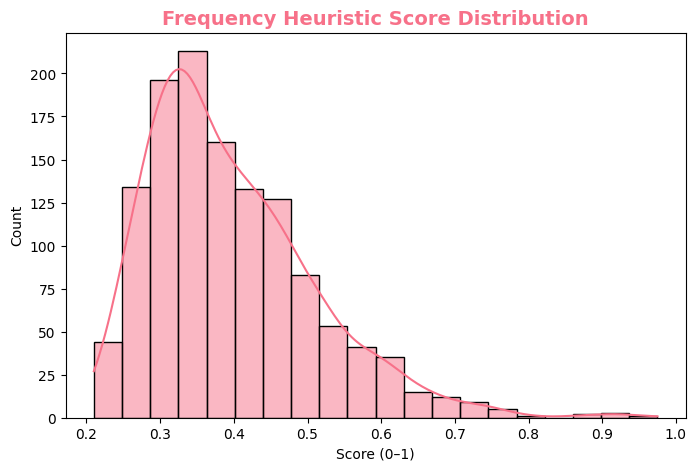

Frequency Heuristic Summary Statistics:
   • Mean Score: 0.397
   • Median Score: 0.375
   • Std. Deviation: 0.114
   • % High-Confidence (Score > 0.8): 0.6%


In [40]:
overview_dashboard(test_results, "Frequency Heuristic", "frequency_heuristic_score")

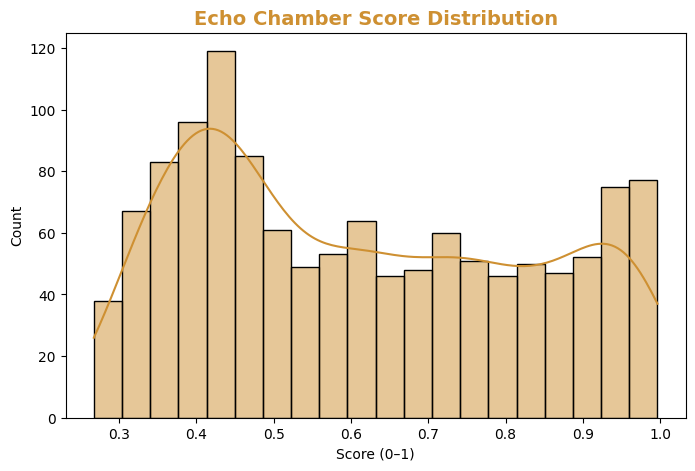

Echo Chamber Summary Statistics:
   • Mean Score: 0.613
   • Median Score: 0.588
   • Std. Deviation: 0.215
   • % High-Confidence (Score > 0.8): 25.1%


In [41]:
overview_dashboard(test_results_echo, "Echo Chamber", "echo_chamber_score")

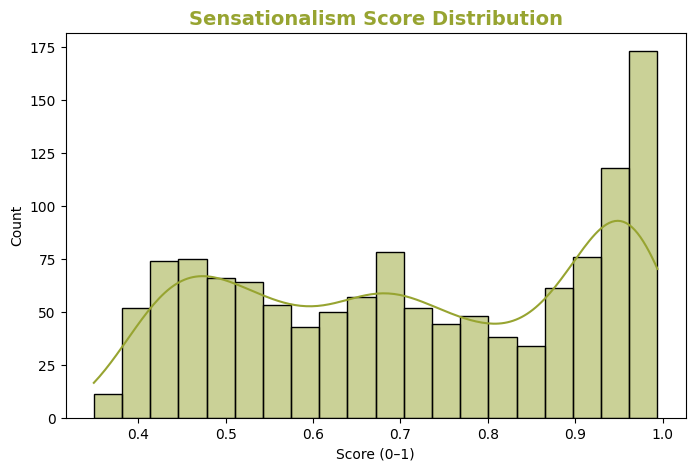

Sensationalism Summary Statistics:
   • Mean Score: 0.717
   • Median Score: 0.712
   • Std. Deviation: 0.198
   • % High-Confidence (Score > 0.8): 39.5%


In [42]:
overview_dashboard(test_results_sens, "Sensationalism", "sensationalism_score")

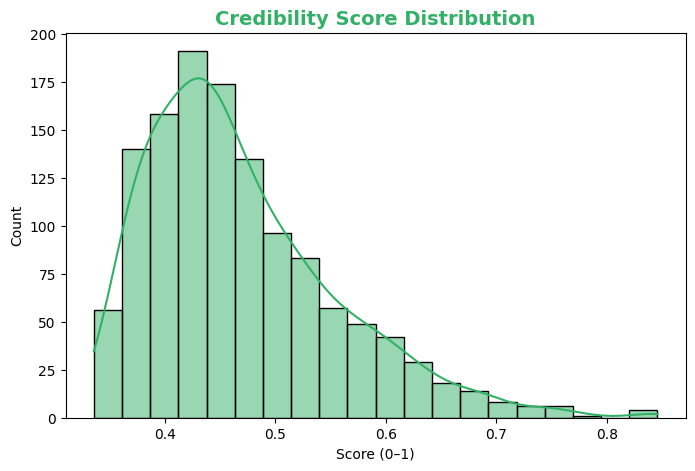

Credibility Summary Statistics:
   • Mean Score: 0.469
   • Median Score: 0.449
   • Std. Deviation: 0.086
   • % High-Confidence (Score > 0.8): 0.3%


In [43]:
overview_dashboard(test_results_cred, "Credibility", "credibility_score")

In [44]:
metrics_list = [
    {
        "Model": "Frequency Heuristic",
        "Accuracy": accuracy_score(df_test["label"], test_results["predicted_label"]),
        "Precision": precision_score(df_test["label"], test_results["predicted_label"], average='weighted', zero_division=0),
        "Recall": recall_score(df_test["label"], test_results["predicted_label"], average='weighted', zero_division=0),
        "F1": f1_score(df_test["label"], test_results["predicted_label"], average='weighted', zero_division=0)
    },
    {
        "Model": "Sensationalism",
        "Accuracy": accuracy_score(df_test["sensationalism"], test_results_sens["predicted_sensationalism"]),
        "Precision": precision_score(df_test["sensationalism"], test_results_sens["predicted_sensationalism"], average='weighted', zero_division=0),
        "Recall": recall_score(df_test["sensationalism"], test_results_sens["predicted_sensationalism"], average='weighted', zero_division=0),
        "F1": f1_score(df_test["sensationalism"], test_results_sens["predicted_sensationalism"], average='weighted', zero_division=0)
    },
    {
        "Model": "Credibility",
        "Accuracy": accuracy_score(df_test["credibility"], test_results_cred["predicted_credibility"]),
        "Precision": precision_score(df_test["credibility"], test_results_cred["predicted_credibility"], average='weighted', zero_division=0),
        "Recall": recall_score(df_test["credibility"], test_results_cred["predicted_credibility"], average='weighted', zero_division=0),
        "F1": f1_score(df_test["credibility"], test_results_cred["predicted_credibility"], average='weighted', zero_division=0)
    }
]

In [45]:
metrics_df = pd.DataFrame(metrics_list)
display(metrics_df.style.background_gradient(cmap="Greens").format(precision=3))

,Model,Accuracy,Precision,Recall,F1
0,Frequency Heuristic,0.207,0.204,0.207,0.205
1,Sensationalism,0.783,0.794,0.783,0.774
2,Credibility,0.438,0.438,0.438,0.435


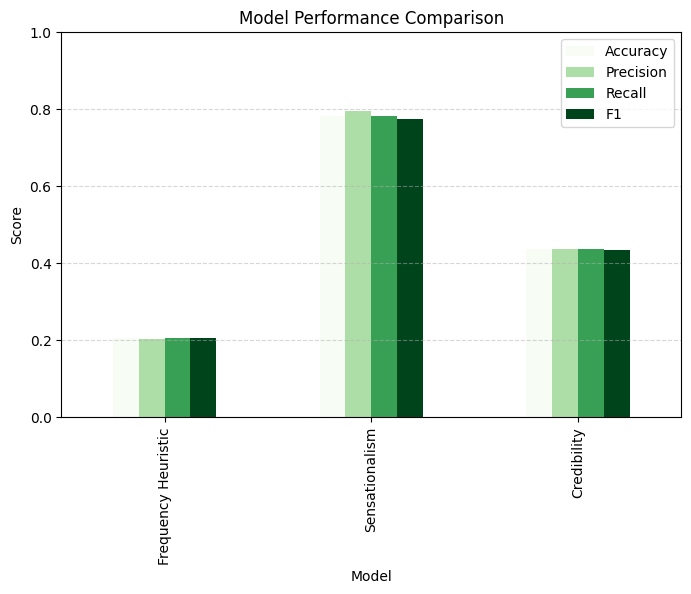

In [46]:
metrics_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]].plot(kind="bar", figsize=(8,5), colormap="Greens")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [47]:
echo_summary = {
    "Mean Confidence": test_results_echo["echo_chamber_score"].mean(),
    "Median Confidence": test_results_echo["echo_chamber_score"].median(),
    "High-Confidence % (>0.8)": (test_results_echo["echo_chamber_score"] > 0.8).mean() * 100,
    "Low-Confidence % (<0.5)": (test_results_echo["echo_chamber_score"] < 0.5).mean() * 100
}

In [48]:
print("Echo Chamber Confidence Summary:")
for k, v in echo_summary.items():
    print(f"   {k}: {v:.2f}")

Echo Chamber Confidence Summary:
   Mean Confidence: 0.61
   Median Confidence: 0.59
   High-Confidence % (>0.8): 25.10
   Low-Confidence % (<0.5): 40.25


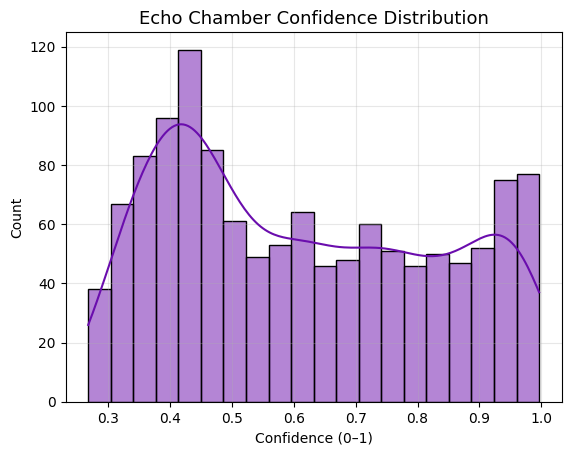

In [49]:
sns.histplot(test_results_echo["echo_chamber_score"], bins=20, kde=True, color="#6A0DAD")
plt.title("Echo Chamber Confidence Distribution", fontsize=13)
plt.xlabel("Confidence (0–1)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

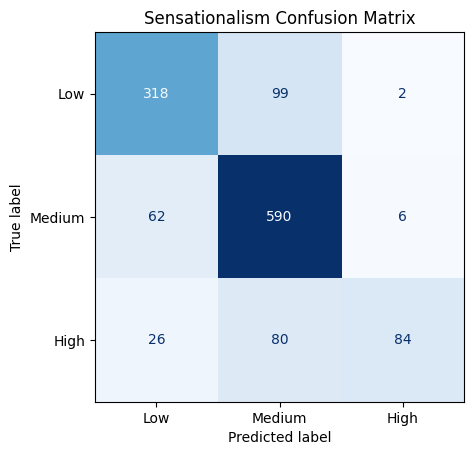

In [51]:
ConfusionMatrixDisplay.from_predictions(
    df_test["sensationalism"],
    test_results_sens["predicted_sensationalism"],
    display_labels=["Low","Medium","High"],
    cmap="Blues", colorbar=False
)
plt.title("Sensationalism Confusion Matrix")
plt.show()

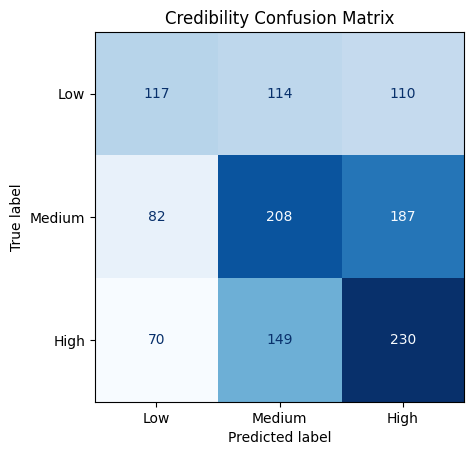

In [52]:
ConfusionMatrixDisplay.from_predictions(
    df_test["credibility"],
    test_results_cred["predicted_credibility"],
    display_labels=["Low","Medium","High"],
    cmap="Blues", colorbar=False
)
plt.title("Credibility Confusion Matrix")
plt.show()

In [53]:
def plot_multiclass_roc(y_true, y_prob, model_name, n_classes=3, colors=None):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    plt.figure(figsize=(7,5))

    if colors is None:
        colors = sns.color_palette("husl", n_classes)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.title(f"{model_name} – ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

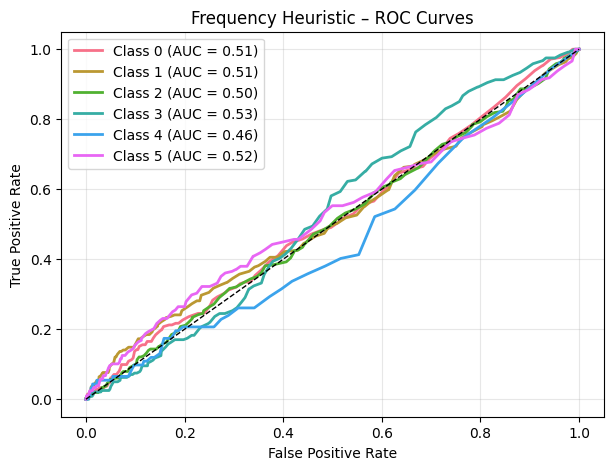

In [56]:
tfidf_vec = tfidf_freq.transform(df_test["statement"])
tfidf_mean = np.asarray(tfidf_vec.mean(axis=1)).ravel()

def safe_word_mean(x):
    if not x:
        return 0
    vals = [token_dict_freq[w] for w in x.lower().split() if w in token_dict_freq]
    return np.mean(vals) if vals else 0

X_test_freq = pd.DataFrame({
    "tfidf_mean": tfidf_mean,
    "word_freq_mean": df_test["statement"].apply(safe_word_mean),
    "buzzword_score": df_test["statement"].apply(lambda x: sum(b in x.lower() for b in buzzwords_freq)),
    "repetition_score": df_test["statement"].apply(
        lambda x: 1 - len(set(x.lower().split()))/len(x.lower().split()) if x else 0
    )
}).fillna(0)

y_true_freq = le_freq.transform(df_test["label"])
y_prob_freq = model_freq.predict_proba(X_test_freq)

plot_multiclass_roc(
    y_true_freq,
    y_prob_freq,
    "Frequency Heuristic",
    n_classes=len(le_freq.classes_)
)

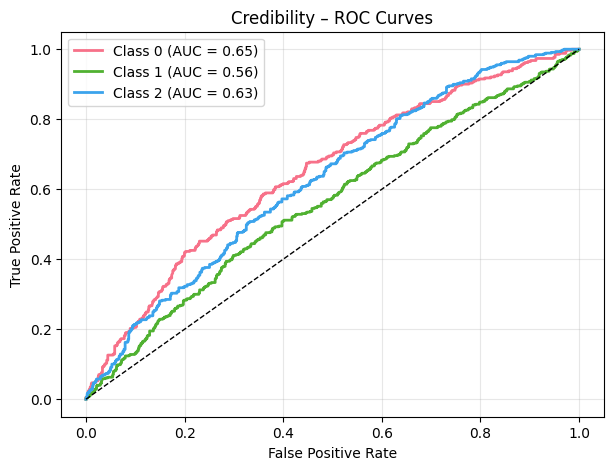

In [57]:
X_test_cred = df_test[["statement","party_encoded","expertise_level","subjectivity"]]
y_true_cred = df_test["credibility"]
y_prob_cred = cred_pipeline.predict_proba(X_test_cred)

plot_multiclass_roc(y_true_cred, y_prob_cred, "Credibility", n_classes=3)